In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

<b> Загрузка и предобработка исходных данных

In [56]:
data = pd.read_csv("../../Практические материалы/Lab 1. Linear and logistic regression/mnist/mnist_train.csv")
data_test = pd.read_csv("../../Практические материалы/Lab 1. Linear and logistic regression/mnist/mnist_test.csv")

In [57]:
data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
X = data.iloc[:,1:].values
X_test = data_test.iloc[:,1:].values

In [59]:
mean = np.mean(X)
std = np.std(X)

X = (X - mean)/std
X_test = (X_test - mean)/std

In [60]:
m = len(X)
n = 10

Y = np.zeros([m,n])

for i in range(m):
    Y[i,data.label.values[i]] = 1

In [7]:
Y

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [8]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [9]:
def tanh(z):
    return (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))

In [10]:
def relu(z):
    return np.max(0,z)

In [11]:
def softmax(z):
    return np.exp(z)/np.sum(np.exp(z), axis = 1).reshape([len(z),1])

In [12]:
def conv(z, filters, padding = 1):
    height = z.shape[0]
    width = z.shape[1]
    depth = z.shape[2]
    samples = z.shape[3]
    n = filters.shape[0]
    m = filters.shape[1]
    l = filters.shape[2]
    n_filters = filters.shape[3]
    
    z_pad = np.zeros([height+padding*2,width+padding*2,depth,samples])
    if padding > 0:
        z_pad[padding:-padding,padding:-padding,:,:] = z[:,:,:,:]
    else:
        z_pad = z
    
    output_h = height + padding * 2 - (n - 1)
    output_w = width + padding * 2 - (n - 1)
    result = np.zeros([output_h,output_w,n_filters,samples])
    
    for s in range(samples):
        for k in range(n_filters):
            for i in range(output_h):
                for j in range(output_w):
                    result[i,j,k,s] = np.sum(z_pad[i:i+n,j:j+m,0:l,s]*filters[:,:,:,k])

    return result

In [13]:
def max_pool(z, pool_size):
    height = z.shape[0]
    width = z.shape[1]
    depth = z.shape[2]
    samples = z.shape[3]
    
    h2 = (pool_size - height%pool_size)%pool_size
    w2 = (pool_size - width%pool_size)%pool_size
        
    z_pad = np.zeros([height+h2,width+w2,depth,samples])
    z_pad[:height,:width,:,:] = z

    result = np.zeros([(height+h2)//pool_size,(width+w2)//pool_size,depth,samples])
        
    for s in range(samples):    
        for k in range(depth):
            for i in range(0,height+h2,pool_size):
                for j in range(0,width+w2,pool_size):
                    tmp = z_pad[i:i+pool_size,j:j+pool_size,k,s]
                    result[i//pool_size,j//pool_size,k,s] = np.max(tmp)
                    
    return result

In [14]:
def avg_pool(z, pool_size):
    height = z.shape[0]
    width = z.shape[1]
    depth = z.shape[2]
    samples = z.shape[3]
    
    h2 = (pool_size - height%pool_size)%pool_size
    w2 = (pool_size - width%pool_size)%pool_size
        
    z_pad = np.zeros([height+h2,width+w2,depth,samples])
    z_pad[:height,:width,:,:] = z[:,:,:,:]

    result = np.zeros([(height+h2)//pool_size,(width+w2)//pool_size,depth,samples])
    
    for s in range(samples):
        for k in range(depth):
            for i in range(0,height+h2,pool_size):
                for j in range(0,width+w2,pool_size):
                    tmp = z_pad[i:i+pool_size,j:j+pool_size,k,s]
                    result[i//pool_size,j//pool_size,k,s] = np.mean(tmp)
                    
    return result

In [15]:
def flatten(z):
    dim0 = z.shape[0]
    dim1 = z.shape[1]
    dim2 = z.shape[2]
    dim3 = z.shape[3]
    
    result = np.zeros([dim3,dim0*dim1*dim2])
    
    for s in range(dim3):
        result[s,:] = z[:,:,:,s].flatten()
    
    return result

In [16]:
def d_conv(filters,f_prev,sigma,padding = 1):
    d_filters = np.zeros_like(filters)
    height = sigma.shape[0]
    width = sigma.shape[1]
    depth = sigma.shape[2]
    samples = sigma.shape[3]
    n = filters.shape[0]
    m = filters.shape[1]
    l = filters.shape[2]
    n_filters = filters.shape[3]
    
    f_prev_pad = np.zeros([f_prev.shape[0]+padding*2,f_prev.shape[1]+padding*2,f_prev.shape[2],f_prev.shape[3]])
    
    if padding > 0:
        f_prev_pad[padding:-padding,padding:-padding,:,:] = f_prev[:,:,:,:]
    else:
        f_prev_pad = f_prev
    
    #print(X)
    sigma_new = np.zeros_like(f_prev_pad)
    
    for s in range(samples):
        for k in range(n_filters):
            for i in range(height):
                for j in range(width):
                    d_filters[:,:,:,k] += f_prev_pad[i:i+n,j:j+m,0:l,s]*sigma[i,j,k,s]
                    sigma_new[i:i+n,j:j+m,0:l,s] += filters[:,:,:,k]*sigma[i,j,k,s]
                
    if padding > 0:
        sigma_new = sigma_new[padding:-padding,padding:-padding,:,:]
                
    return d_filters,sigma_new

In [17]:
def d_flat(z,size):
    dim0 = size[0]
    dim1 = size[1]
    dim2 = size[2]
    dim3 = size[3]
    
    result = np.zeros(size)
    
    for s in range(dim3):
        result[:,:,:,s] = z[s,:].reshape([dim0,dim1,dim2])
    
    return result

In [18]:
def d_max_pool(sigma,f_prev,pool_size):
    result = np.zeros([sigma.shape[0]*pool_size,sigma.shape[1]*pool_size,sigma.shape[2],sigma.shape[3]])

    for s in range(sigma.shape[3]):
        for k in range(sigma.shape[2]):
            for i in range(0,sigma.shape[0]*pool_size,pool_size):
                for j in range(0,sigma.shape[1]*pool_size,pool_size):
                    tmp = f_prev[i:i+pool_size,j:j+pool_size,k,s]
                    max_ind = np.argmax(tmp.flatten())
                    
                    result[i+max_ind//pool_size,j+max_ind%pool_size,k,s] = sigma[i//pool_size,j//pool_size,k,s]

    return result

In [19]:
def d_avg_pool(sigma,f_prev,pool_size):
    result = np.zeros([sigma.shape[0]*pool_size,sigma.shape[1]*pool_size,sigma.shape[2],sigma.shape[3]])

    for s in range(sigma.shape[3]):
        for k in range(sigma.shape[2]):
            for i in range(0,sigma.shape[0]*pool_size,pool_size):
                for j in range(0,sigma.shape[1]*pool_size,pool_size):
                    result[i:i+pool_size,j:j+pool_size,k,s] = sigma[i//pool_size,j//pool_size,k,s]

    return result/pool_size**2

In [20]:
def d_softmax(z,sigma):
    d_softmax = np.zeros([z.shape[1],z.shape[1],z.shape[0]])
    
    for k in range(z.shape[0]):
        for i in range(d_softmax.shape[0]):
            for j in range(d_softmax.shape[1]):
                if i == j:
                    d_softmax[i,j,k] += z[k,i]*(1-z[k,j])
                else:
                    d_softmax[i,j,k] += -z[k,i]*z[k,j]
    
    sigma_new = np.zeros_like(sigma)
    for k in range(z.shape[0]):
        sigma_new[k,:] = np.matmul(sigma[k:k+1,:],d_softmax[:,:,k]).flatten()
    
    return sigma_new

In [21]:
def forward(X,filters,W,B,pool_size):
    F0 = conv(X,filters[0],padding=2)
    F1 = tanh(F0)
    F2 = avg_pool(F1,pool_size)
    F3 = conv(F2,filters[1],padding=0)
    F4 = tanh(F3)
    F5 = avg_pool(F4,pool_size)
    F6 = conv(F5,filters[2],padding=0)
    F7 = tanh(F6)
    F8 = flatten(F7)
    F9 = tanh(np.matmul(F8,W[0]) + B[0])
    F10 = softmax(np.matmul(F9,W[1]) + B[1])
    
    return (F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10)

In [22]:
def backprop(X,F,W,Y,filters,pool_size):
    sigma = (F[10] - Y)/(F[10]*(1-F[10]))
    sigma = d_softmax(F[10],sigma)
    
    dW2 = np.matmul(F[9].T,sigma)
    dB2 = np.sum(sigma, axis = 0)
    
    sigma = np.matmul(sigma,W[1].T)
    sigma = sigma*(1-F[9]*F[9])
    
    dW1 = np.matmul(F[8].T,sigma)
    dB1 = np.sum(sigma, axis = 0)
    
    sigma = np.matmul(sigma,W[0].T)
    sigma = d_flat(sigma,F[7].shape)
    sigma = sigma*(1-F[7]*F[7])
    
    d_filters3,sigma = d_conv(filters[2],F[5],sigma,padding=0)
    sigma = d_avg_pool(sigma,F[4],pool_size)
    
    sigma = sigma*(1-F[4]*F[4])
    
    d_filters2,sigma = d_conv(filters[1],F[2],sigma,padding=0)
    sigma = d_avg_pool(sigma,F[1],pool_size) 
    
    sigma = sigma*(1-F[1]*F[1])
    d_filters1,sigma = d_conv(filters[0],X,sigma,padding=2)
    
    return (dW2,dB2,dW1,dB1,d_filters3,d_filters2,d_filters1)    

In [71]:
#filters1 = np.random.randn(5,5,1,6)
#filters2 = np.random.randn(5,5,6,16)
#filters3 = np.random.randn(5,5,16,120)

#filters = [filters1,filters2,filters3]

#W1 = np.random.randn(120,84)
#B1 = np.random.randn(1,84)
#W2 = np.random.randn(84,10)
#B2 = np.random.randn(1,10)

#W = [W1,W2]
#B = [B1,B2]

pool_size = 2

batch_size = 100

m = len(X)

alpha = 0.01

#Js = []

# Adam optimizer

v_filters1 = np.zeros_like(filters1)
v_filters2 = np.zeros_like(filters2)
v_filters3 = np.zeros_like(filters3)
v_W2 = np.zeros_like(W2)
v_B2 = np.zeros_like(B2)
v_W1 = np.zeros_like(W1)
v_B1 = np.zeros_like(B1)

m_filters1 = np.zeros_like(filters1)
m_filters2 = np.zeros_like(filters2)
m_filters3 = np.zeros_like(filters3)
m_W2 = np.zeros_like(W2)
m_B2 = np.zeros_like(B2)
m_W1 = np.zeros_like(W1)
m_B1 = np.zeros_like(B1)

v_hat_filters1 = np.zeros_like(filters1)
v_hat_filters2 = np.zeros_like(filters2)
v_hat_filters3 = np.zeros_like(filters3)
v_hat_W2 = np.zeros_like(W2)
v_hat_B2 = np.zeros_like(B2)
v_hat_W1 = np.zeros_like(W1)
v_hat_B1 = np.zeros_like(B1)

m_hat_filters1 = np.zeros_like(filters1)
m_hat_filters2 = np.zeros_like(filters2)
m_hat_filters3 = np.zeros_like(filters3)
m_hat_W2 = np.zeros_like(W2)
m_hat_B2 = np.zeros_like(B2)
m_hat_W1 = np.zeros_like(W1)
m_hat_B1 = np.zeros_like(B1)

beta1 = 0.90
beta2 = 0.90

X_tst = np.zeros([28,28,1,100])
for k in range(100):
    X_tst[:,:,0,k] = X_test[k,:].reshape([28,28])
Y_tst = data_test.label.values[0:100]

for t in range(0,m,batch_size):
    X_batch = np.zeros([28,28,1,batch_size])
    for k in range(batch_size):
        X_batch[:,:,0,k] = X[t+k,:].reshape([28,28])
        
    Y_batch = Y[t:t+batch_size,:]
    F = forward(X_batch,filters,W,B,pool_size)
        
    J = -np.sum(Y_batch*np.log(F[-1])+(1-Y_batch)*np.log(1-F[-1]))
    Js.append(J)
    
    print(Js[-1], np.mean(Js[-15:]))
        
    grads = backprop(X_batch,F,W,Y_batch,filters,pool_size)

    m_filters1 = beta1*m_filters1 + (1 - beta1)*grads[6]
    m_filters2 = beta1*m_filters2 + (1 - beta1)*grads[5]
    m_filters3 = beta1*m_filters3 + (1 - beta1)*grads[4]
    m_W2 = beta1*m_W2 + (1 - beta1)*grads[0]
    m_B2 = beta1*m_B2 + (1 - beta1)*grads[1]
    m_W1 = beta1*m_W1 + (1 - beta1)*grads[2]
    m_B1 = beta1*m_B1 + (1 - beta1)*grads[3]
    
    v_filters1 = beta2*v_filters1 + (1 - beta2)*grads[6]**2
    v_filters2 = beta2*v_filters2 + (1 - beta2)*grads[5]**2
    v_filters3 = beta2*v_filters3 + (1 - beta2)*grads[4]**2
    v_W2 = beta2*v_W2 + (1 - beta2)*grads[0]**2
    v_B2 = beta2*v_B2 + (1 - beta2)*grads[1]**2
    v_W1 = beta2*v_W1 + (1 - beta2)*grads[2]**2
    v_B1 = beta2*v_B1 + (1 - beta2)*grads[3]**2

    m_hat_filters1 = m_filters1/(1-beta1**(t+1))
    m_hat_filters2 = m_filters2/(1-beta1**(t+1))
    m_hat_filters3 = m_filters3/(1-beta1**(t+1))
    m_hat_W2 = m_W2/(1-beta1**(t+1))
    m_hat_B2 = m_B2/(1-beta1**(t+1))
    m_hat_W1 = m_W1/(1-beta1**(t+1))
    m_hat_B1 = m_B1/(1-beta1**(t+1))

    v_hat_filters1 = v_filters1/(1-beta2**(t+1))
    v_hat_filters2 = v_filters2/(1-beta2**(t+1))
    v_hat_filters3 = v_filters3/(1-beta2**(t+1))
    v_hat_W2 = v_W2/(1-beta2**(t+1))
    v_hat_B2 = v_B2/(1-beta2**(t+1))
    v_hat_W1 = v_W1/(1-beta2**(t+1))
    v_hat_B1 = v_B1/(1-beta2**(t+1))    
    
    W2 += -alpha*m_hat_W2/(np.sqrt(v_hat_W2+0.00001))
    B2 += -alpha*m_hat_B2/(np.sqrt(v_hat_B2+0.00001))
    W1 += -alpha*m_hat_W1/(np.sqrt(v_hat_W1+0.00001))
    B1 += -alpha*m_hat_B1/(np.sqrt(v_hat_B1+0.00001))
    filters3 += -alpha*m_hat_filters3/(np.sqrt(v_hat_filters3+0.00001))
    filters2 += -alpha*m_hat_filters2/(np.sqrt(v_hat_filters2+0.00001))
    filters1 += -alpha*m_hat_filters1/(np.sqrt(v_hat_filters1+0.00001))

    F = forward(X_tst,filters,W,B,pool_size)
    predict = np.argmax(F[-1],axis = 1)
    print('acc:',np.mean(predict == Y_tst))

421.58048140585606 330.3614435589921
acc: 0.41
306.58793924164144 327.65365575866207
acc: 0.46
259.412015156586 323.36716946318876
acc: 0.47
208.21547870526746 319.93845281871285
acc: 0.53
253.0531136463273 310.9786336936534
acc: 0.54
245.43314606363464 306.3247672624224
acc: 0.56
296.1150182332459 302.2859261351425
acc: 0.56
243.73137730509296 293.6316410900778
acc: 0.58
266.1612178911816 288.9403269212301
acc: 0.58
239.157770520668 286.46617487984787
acc: 0.65
258.0006668849255 290.09314653380886
acc: 0.63
245.0438786742986 283.7285332597868
acc: 0.6
258.18533205453554 276.0565677076948
acc: 0.55
259.368168551372 272.4028451540782
acc: 0.55
201.56325034960184 264.107256978949
acc: 0.55
207.49102798858783 249.83462675113108
acc: 0.57
213.5773803891438 243.63392282763127
acc: 0.56
168.1440120306603 237.5493892859029
acc: 0.55
207.174666681468 237.4800018176496
acc: 0.53
222.75231058777774 235.45994828041293
acc: 0.55
238.05570177589095 234.96811866123005
acc: 0.52
200.50734386217943 22

KeyboardInterrupt: 

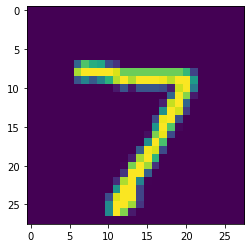

In [76]:
plt.imshow(X_tst[:,:,0,0])

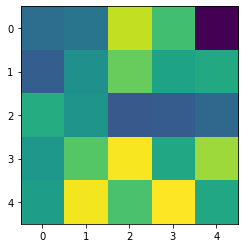

In [149]:
plt.imshow(filters3[:,:,0,70])

In [ ]:
for i in range(0,m,batch_size):
    X_batch = np.zeros([28,28,1,batch_size])
    for k in range(batch_size):
        X_batch[:,:,0,k] = X[i+k,:].reshape([28,28])
        
    Y_batch = Y[i:i+batch_size,:]
    F = forward(X_batch,filters,W,B,pool_size)
    J = -np.sum(Y_batch*np.log(F[-1])+(1-Y_batch)*np.log(1-F[-1]))
    Js.append(J)
    
    print(np.mean(Js[-15:]))
    
    grads = backprop(X_batch,F,W,Y_batch,filters,pool_size)
    
    W2 = W2 - alpha*grads[0]
    B2 = B2 - alpha*grads[1]
    W1 = W1 - alpha*grads[2]
    B1 = B1 - alpha*grads[3]
    filters3 = filters3 - alpha*grads[4]
    filters2 = filters2 - alpha*grads[5]
    filters1 = filters1 - alpha*grads[6]

In [ ]:
grads = backprop(X,F,W,Y,filters,pool_size)

In [ ]:
F = forward(X,filters,W,B,pool_size)
J1 = -np.sum(Y*np.log(F[-1])+(1-Y)*np.log(1-F[-1]))
filters1[3,3,0,0] += 0.0000001
F = forward(X,filters,W,B,pool_size)
J2 = -np.sum(Y*np.log(F[-1])+(1-Y)*np.log(1-F[-1]))
filters1[3,3,0,0] -= 0.0000001
print((J2-J1)/0.0000001)

In [ ]:
grads[6][3,3,0,0]

In [198]:
X_test.shape

(10000, 784)

In [199]:
X_tst = np.zeros([28,28,1,100])
for i in range(100):
    X_tst[:,:,0,i] = X_test[i,:].reshape(28,28)

In [202]:
from tqdm import tqdm

pred = []
for i in tqdm(range(100)):
    F = forward(X_tst[:,:,:,i:i+1],filters,W,B,pool_size)
    pred.append(np.argmax(F[-1]))

100%|██████████| 100/100 [00:05<00:00, 16.77it/s]


In [206]:
np.mean(pred == data_test.label.values[0:100])

0.15

In [ ]:
from keras import Sequential
from keras.layers import Conv2D, Flatten, AveragePooling2D, Dense
from keras.optimizers import Adam, SGD

In [ ]:
model = Sequential()

model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='tanh', padding = 'same', input_shape=(28,28,1)))
model.add(AveragePooling2D())

model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='tanh', padding = 'valid'))
model.add(AveragePooling2D())

model.add(Conv2D(filters=120, kernel_size=(5, 5), activation='tanh', padding = 'valid'))

model.add(Flatten())

model.add(Dense(units=84, activation='tanh'))

model.add(Dense(units=10, activation = 'softmax'))

opt = Adam()

model.compile(optimizer = opt, loss = 'categorical_crossentropy',metrics = ['categorical_crossentropy','accuracy'])

model.summary()

In [ ]:
X_train = np.zeros([60000,28,28,1])
for i in range(60000):
    X_train[i,:,:,0] = X[i,:].reshape(28,28)

In [ ]:
model.fit(X_train, Y, batch_size = 1, epochs=10)

In [ ]:
Доделать производные других слоев

Обучить 1 итерацию сравнить ошибку с Keras для разных размеров батча

batch = 1

Сделать batch_normalization

Сделать dropout